In [1]:
import numpy as np
import numba as nb
from numba import config, njit, prange, threading_layer
from numba import int64
from numba.typed import List
from tqdm.notebook import tqdm, trange
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

In [2]:
%matplotlib notebook

In [3]:
def square_lattice_to_hex(lattice):
    def roll_even(i, arr):
        if i%2 == 0:
            return np.roll(arr, 1)
        else:
            return arr
    
    lattice_rep_cols = np.repeat(lattice, 2, axis=1)
    
    rolled = np.array([roll_even(i, arr) for i, arr in enumerate(lattice_rep_cols)])
    hex_lattice = np.repeat(rolled, 2, axis=0)
    return hex_lattice

In [4]:
@njit
def check(lattice:np.ndarray, queue):
    
    L, _ = lattice.shape
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    diag_top  = lambda xy: ((xy[0] + 1 - 2*(xy[1]%2))%L, (xy[1] + 1)%L)
    diag_down = lambda xy: ((xy[0] + 1 - 2*(xy[1]%2))%L, (xy[1] - 1)%L)
    
    counter = 0
    
    xz, yz = np.where(lattice == 1)
    zlist = List()
    
    for i in range(len(xz)):
        zlist.append((xz[i], yz[i]))
    #zlist = np.transpose(np.array(np.where(lattice == 1)))
    
    for xyz in zlist:

        for xyn in left(xyz), right(xyz), up(xyz), down(xyz), diag_top(xyz), diag_down(xyz):
            if lattice[xyn] == 0:
                counter = counter + 1
                if (xyz, xyn) not in queue:
                    print(xyz, xyn)
                    return False
                
    if counter == len(queue):
        return True
    else:
        print(counter, len(queue))
        return False
    
@njit
def update(lattice:np.ndarray, queue:list, k:float, b:float):
    
    L, _ = lattice.shape
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    diag_top  = lambda xy: ((xy[0] + 1 - 2*(xy[1]%2))%L, (xy[1] + 1)%L)
    diag_down = lambda xy: ((xy[0] + 1 - 2*(xy[1]%2))%L, (xy[1] - 1)%L)
    
    if len(queue) == 0:
        return lattice, queue
    
    ind = np.random.randint(len(queue))
    r = np.random.uniform(0, 1)
    
    if r < b/(b + k):
        xyz, xys = queue.pop(ind)
        assert(lattice[xyz] == 1)
        assert(lattice[xys] == 0)
        lattice[xys] = 1
        
        for xyn in left(xys), right(xys), up(xys), down(xys), diag_top(xys), diag_down(xys):
            if lattice[xyn] == 0:
                queue.append((xys, xyn))
                
        
        if len(queue) == 0:
            return lattice, queue
        
        for xyn in left(xys), right(xys), up(xys), down(xys), diag_top(xys), diag_down(xys):
            if lattice[xyn] == 1 and xyn != xyz:
                queue.remove((xyn, xys))
 
        

    else:
        xyz, xys = queue.pop(ind)
        assert(lattice[xyz] == 1)
        assert(lattice[xys] == 0)
        lattice[xyz] = 2
        
        if len(queue) == 0:
            return lattice, queue
        
        for xyn in left(xyz), right(xyz), up(xyz), down(xyz), diag_top(xyz), diag_down(xyz):
            if lattice[xyn] == 0 and xyn != xys:
                queue.remove((xyz, xyn))
               
    
    return lattice, queue



@njit
def init_lattice(L:int, xy0):
    
    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    diag_top  = lambda xy: ((xy[0] + 1 - 2*(xy[1]%2))%L, (xy[1] + 1)%L)
    diag_down = lambda xy: ((xy[0] + 1 - 2*(xy[1]%2))%L, (xy[1] - 1)%L)
    
    lattice = np.zeros((L, L), dtype = int64)
    lattice[xy0] = 1
    queue = List()
    queue.append((xy0,  left(xy0)))
    queue.append((xy0, right(xy0)))
    queue.append((xy0,    up(xy0)))
    queue.append((xy0,  down(xy0)))
    queue.append((xy0, diag_top(xy0)))
    queue.append((xy0, diag_down(xy0)))
    
    return lattice, queue

@njit
def init_lattice_(lattice:np.ndarray, queue:list, xy0):
    
    L, _ = lattice.shape

    left   = lambda xy: ((xy[0]-1)%L, xy[1]      )
    right  = lambda xy: ((xy[0]+1)%L, xy[1]      )
    up     = lambda xy: (      xy[0], (xy[1]+1)%L)
    down   = lambda xy: (      xy[0], (xy[1]-1)%L)
    diag_top  = lambda xy: ((xy[0] + 1 - 2*(xy[1]%2))%L, (xy[1] + 1)%L)
    diag_down = lambda xy: ((xy[0] + 1 - 2*(xy[1]%2))%L, (xy[1] - 1)%L)
    
    lattice[:, :] = 0
    lattice[xy0] = 1
    
    queue = List()
    queue.append((xy0,  left(xy0)))
    queue.append((xy0, right(xy0)))
    queue.append((xy0,    up(xy0)))
    queue.append((xy0,  down(xy0)))
    queue.append((xy0, diag_top(xy0)))
    queue.append((xy0, diag_down(xy0)))

    
    return lattice, queue
    

@njit
def run_lattice_(lattice:np.ndarray, queue:list, k:float, b:float):

    counter = 0    
    while len(queue) != 0:
        counter = counter + 1
        lattice, queue = update(lattice, queue, k, b)
        
#        if counter%100 == 0:
#            print(str(counter) + ":" + str(time.time() - start_time))
            
    return lattice, queue

def run_lattice(lattice:np.ndarray, queue, k:float, b:float):
    start_time = time.time()
    lattice, queue = run_lattice_(lattice, queue, k, b)
    print(time.time() - start_time)
    
    return lattice, queue

  
def run_check_lattice(L:int, xy0, k:float, b:float):
    
    lattice, queue = init_lattice(L, xy0)
    counter = 0
    while len(queue) != 0:
        
        if check(lattice, queue) == False:
            print("error")
            break
           
        counter = counter + 1
        lattice, queue = update(lattice, queue, k, b)
        
#        if counter%100 == 0:
#            print(str(counter) + ":" + str(time.time() - start_time))
        
    return lattice, queue
config.THREADING_LAYER = 'threadsafe'
@njit(parallel = True)
def cluster_size(s_list:np.ndarray, lattice:np.ndarray, queue:list):
    N = s_list.shape[0]    
    for i in prange(N):
        lattice, queue = init_lattice(512, (256, 256))
        lattice, queue = run_lattice_(lattice, queue, 0.67, 1)
        s_list[i] = np.count_nonzero(lattice)
        #print("iteration:", i)
    return s_list

@njit
def nb_seed(seed):
    np.random.seed(seed)

In [5]:
nb_seed(524149)

In [73]:
s_list = np.zeros(10000, dtype = int)
lattice, queue = init_lattice(512, (256, 256))
start_time = time.time()
s_list = cluster_size(s_list, lattice, queue)
print(time.time() - start_time)

642.490965127945


<IPython.core.display.Javascript object>


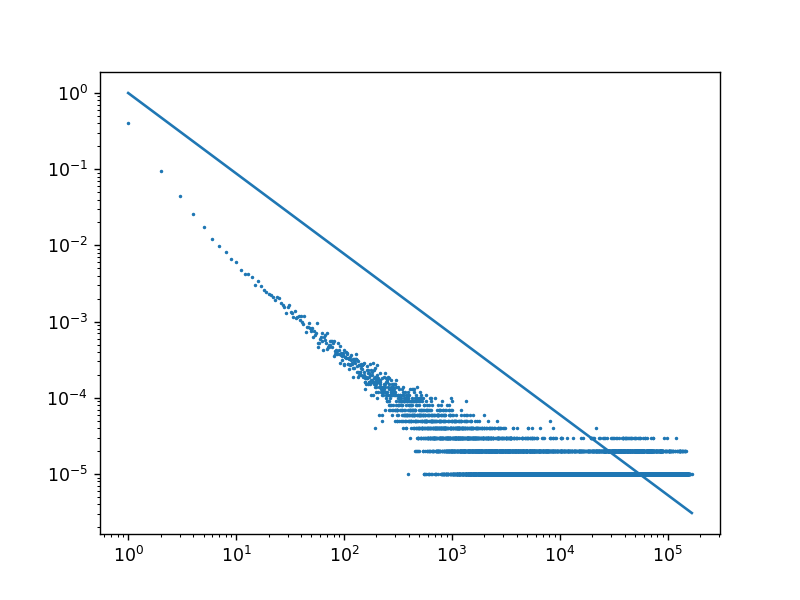

In [76]:
# N=100'000, L=512, ? cpu, 640s
s, counts = np.unique(s_list, return_counts = True)

plt.scatter(s, counts/np.sum(counts), s = 1)
    
plt.plot(s, np.power(s, 1-187/91))
plt.xscale('log')
plt.yscale('log')
plt.show()

<IPython.core.display.Javascript object>


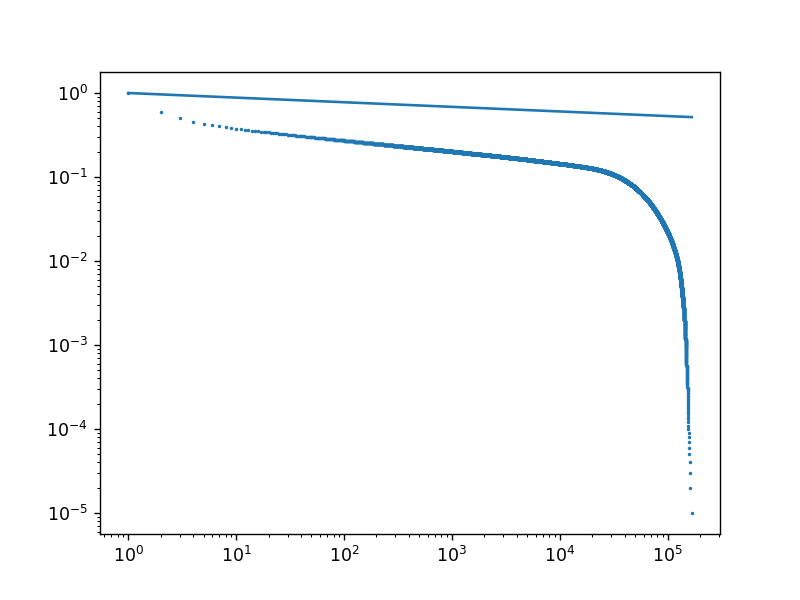

In [103]:
plt.close()
s, counts = np.unique(s_list, return_counts = True)

plt.scatter(s, (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts), s = 1)
    
plt.plot(s, np.power(s, 2-187/91))
#plt.plot(s, np.power(s, -187/91))
plt.xscale('log')
plt.yscale('log')

In [57]:
plt.close()

0.886176347732544


<IPython.core.display.Javascript object>


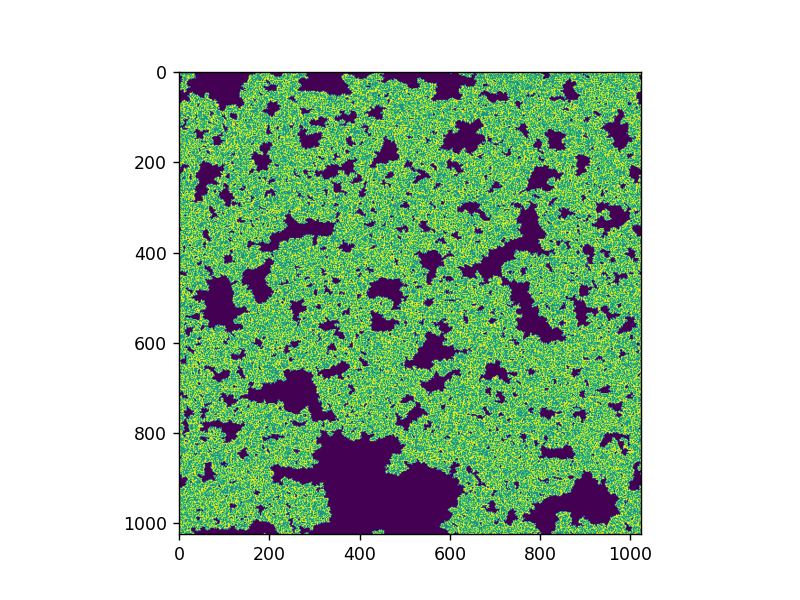

In [60]:
lattice, queue = init_lattice(512, (256, 256))

lattice, queue = run_lattice(lattice, queue, 0.527, 1)

plt.imshow(square_lattice_to_hex(lattice))

In [301]:
plt.close()

## Using Euler cluster

$ P_{s} \sim s^{1 - \tau}$

$\tau = 187/ 91$

$P_{\geq s} \sim s^{ 2 - \tau} $

In [303]:
plt.close()

<IPython.core.display.Javascript object>


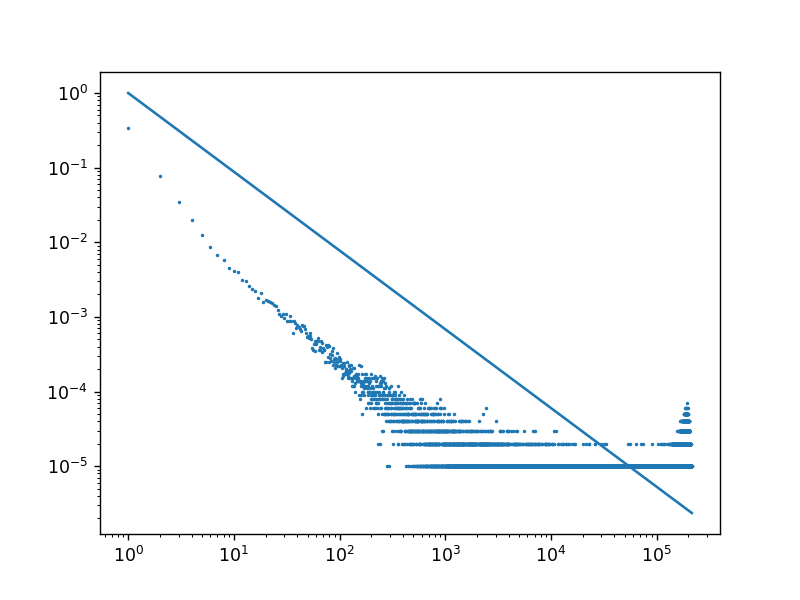

<IPython.core.display.Javascript object>


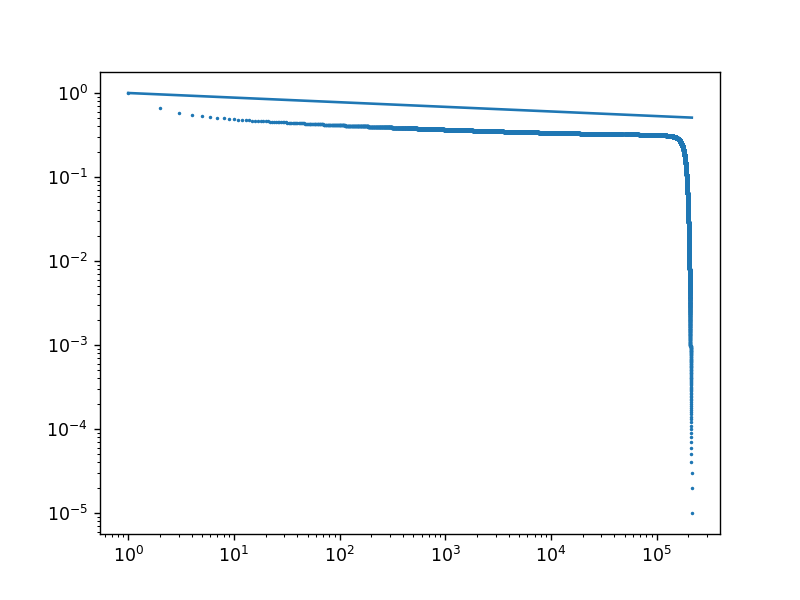

<IPython.core.display.Javascript object>


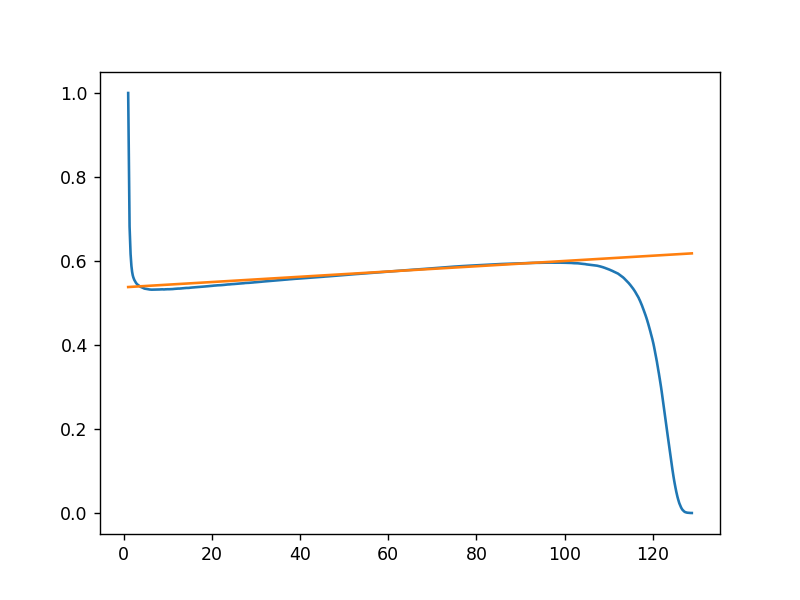

In [15]:
# 883 [sec]
for f in ["s_list_100000_512_0.524.npy"]:
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    s_sig = np.power(s, 36/91)
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    plt.close()
    plt.figure(1)
    plt.scatter(s, counts/np.sum(counts), s = 1)
    plt.plot(s, np.power(s, 1-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2)
    plt.scatter(s, pgts, s = 1)
    plt.plot(s, np.power(s, 2-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(3)
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts)
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    plt.plot(s_sig, k*s_sig + b)
plt.show()

In [62]:
plt.close()

<IPython.core.display.Javascript object>


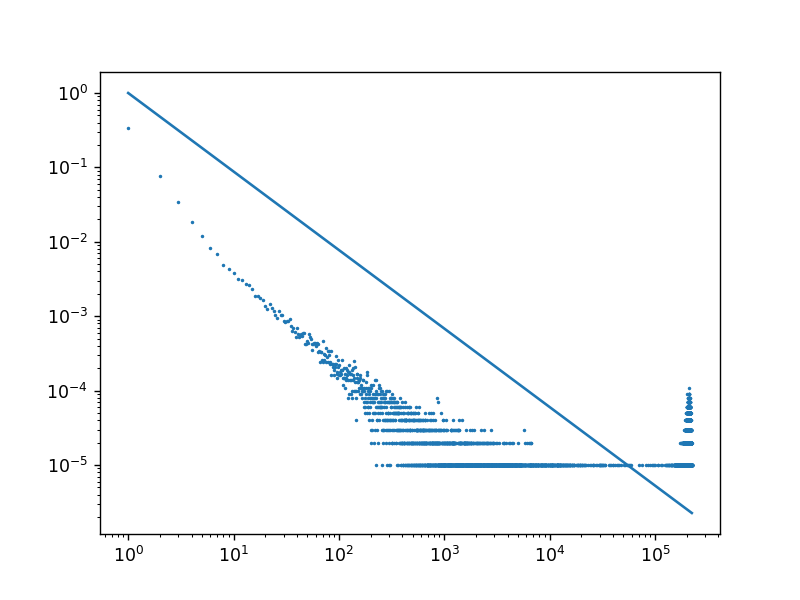

<IPython.core.display.Javascript object>


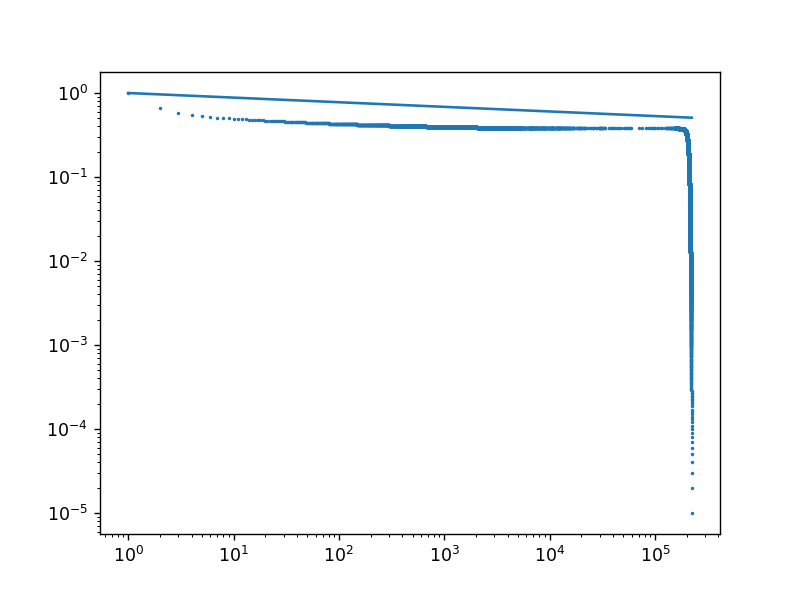

<IPython.core.display.Javascript object>


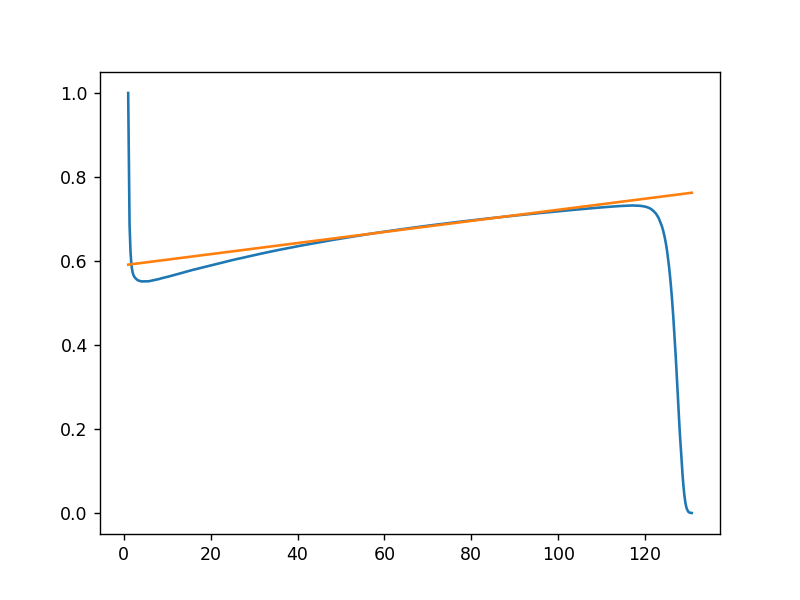

In [63]:
# 1587 [sec]
for f in ["s_list_100000_512_0.515.npy"]:
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    s_sig = np.power(s, 36/91)
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    plt.close()
    plt.figure(1)
    plt.scatter(s, counts/np.sum(counts), s = 1)
    plt.plot(s, np.power(s, 1-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2)
    plt.scatter(s, pgts, s = 1)
    plt.plot(s, np.power(s, 2-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(3)
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts)
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    plt.plot(s_sig, k*s_sig + b)
plt.show()

In [65]:
plt.close()

<IPython.core.display.Javascript object>


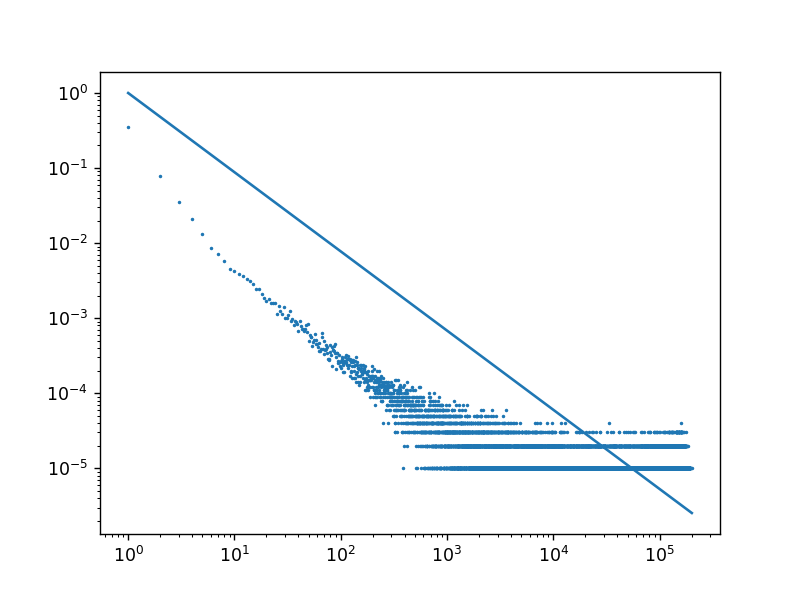

<IPython.core.display.Javascript object>


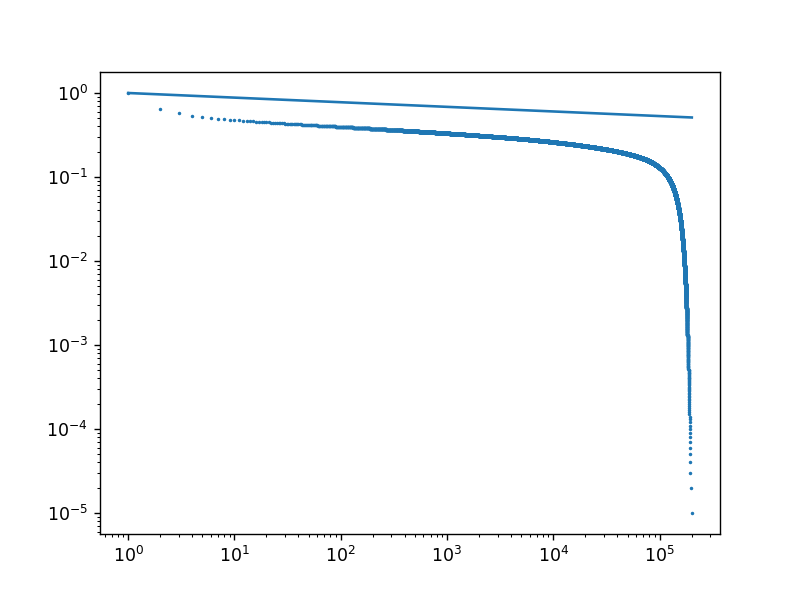

<IPython.core.display.Javascript object>


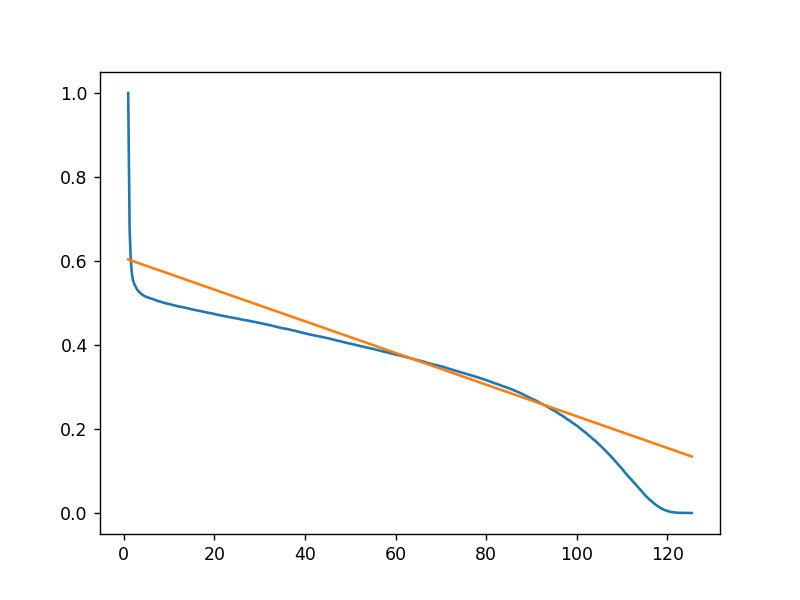

In [66]:
# 236 [sec]
for f in ["s_list_100000_512_0.535.npy"]:
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    s_sig = np.power(s, 36/91)
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    plt.close()
    plt.figure(1)
    plt.scatter(s, counts/np.sum(counts), s = 1)
    plt.plot(s, np.power(s, 1-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2)
    plt.scatter(s, pgts, s = 1)
    plt.plot(s, np.power(s, 2-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(3)
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts)
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    plt.plot(s_sig, k*s_sig + b)
plt.show()

In [68]:
plt.close()

<IPython.core.display.Javascript object>


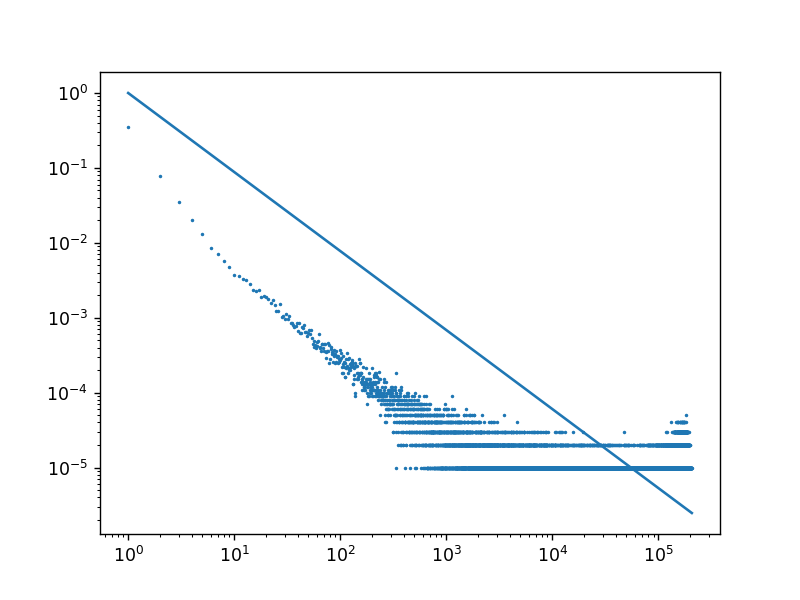

<IPython.core.display.Javascript object>


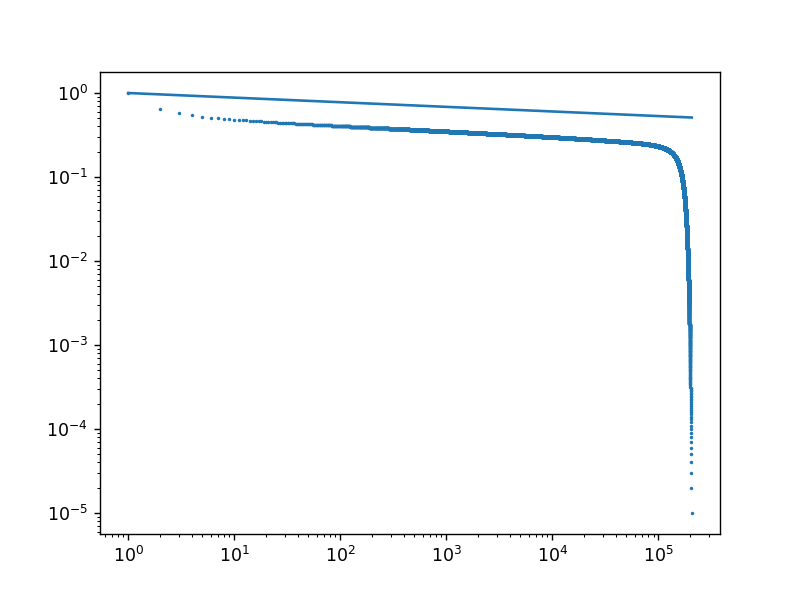

<IPython.core.display.Javascript object>


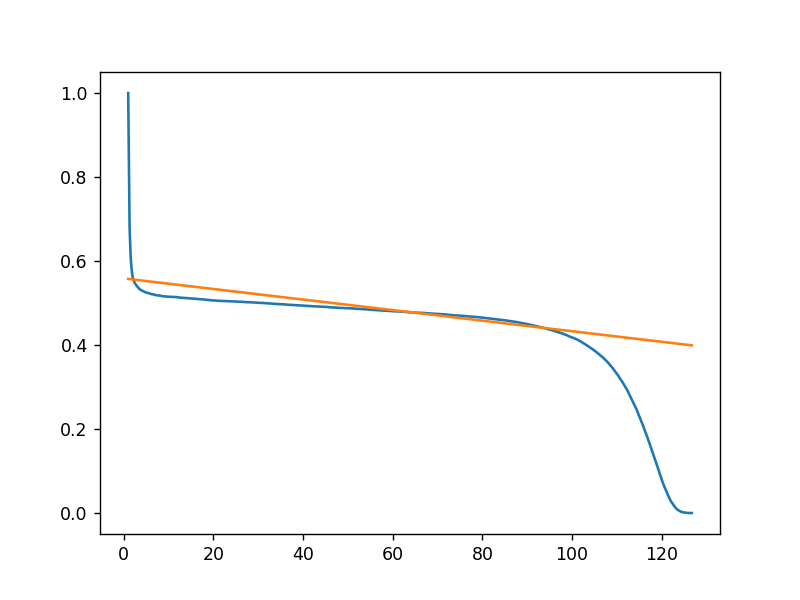

In [69]:
# 498 [sec]
for f in ["s_list_100000_512_0.53.npy"]:
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    s_sig = np.power(s, 36/91)
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    plt.close()
    plt.figure(1)
    plt.scatter(s, counts/np.sum(counts), s = 1)
    plt.plot(s, np.power(s, 1-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2)
    plt.scatter(s, pgts, s = 1)
    plt.plot(s, np.power(s, 2-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(3)
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts)
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    plt.plot(s_sig, k*s_sig + b)
plt.show()

In [71]:
plt.close()

<IPython.core.display.Javascript object>


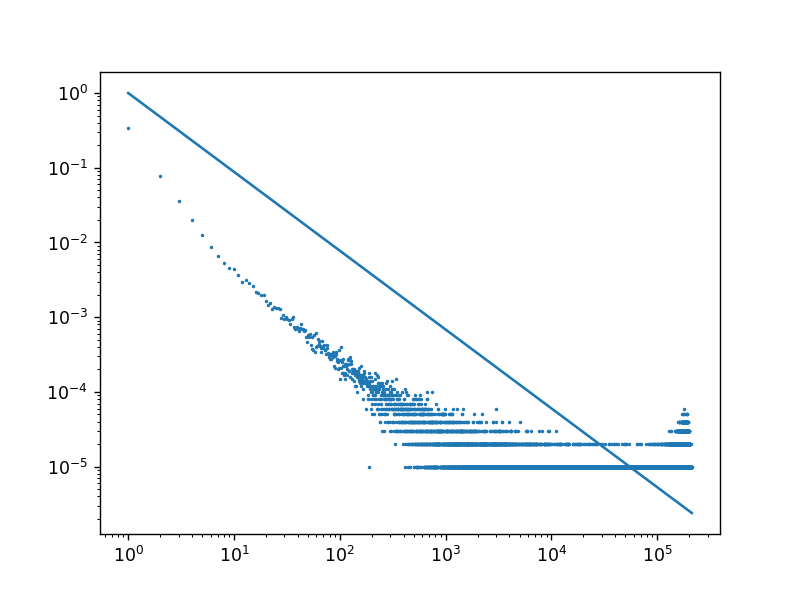

<IPython.core.display.Javascript object>


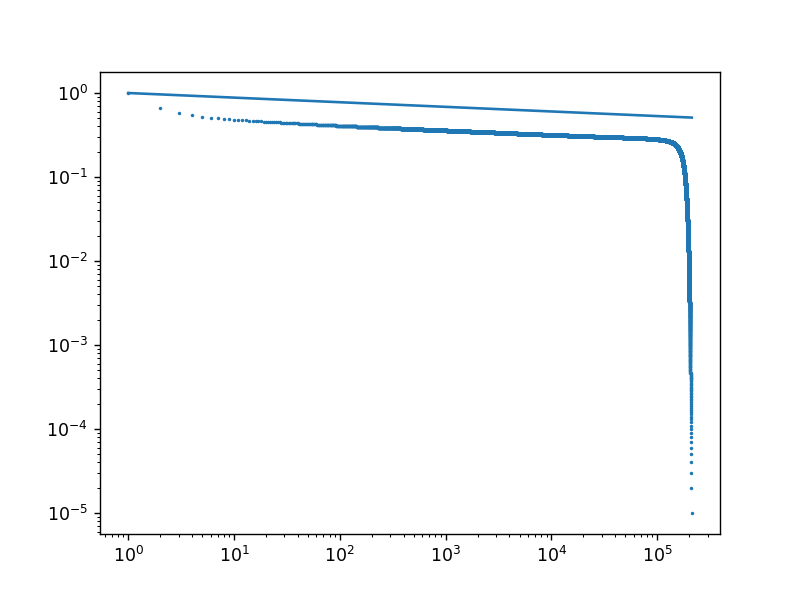

<IPython.core.display.Javascript object>


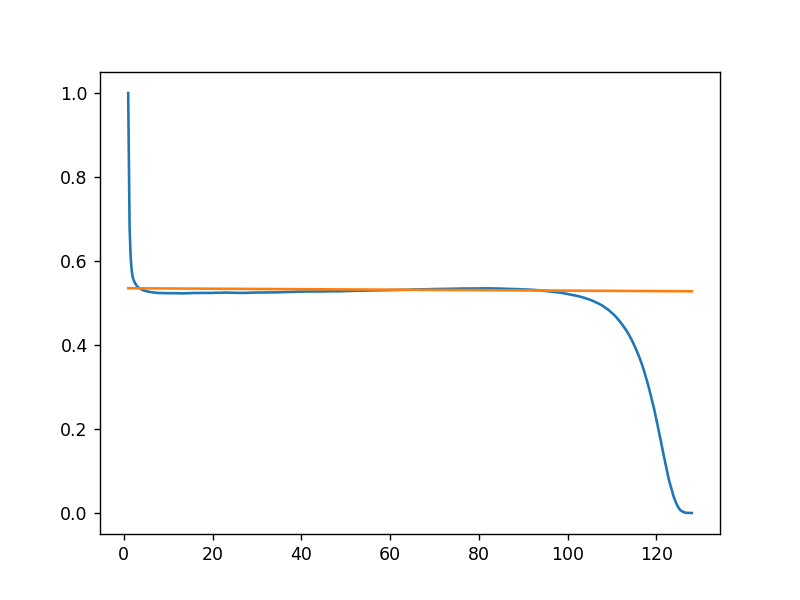

In [72]:
# 639 [sec]
for f in ["s_list_100000_512_0.527.npy"]:
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    s_sig = np.power(s, 36/91)
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    plt.close()
    plt.figure(1)
    plt.scatter(s, counts/np.sum(counts), s = 1)
    plt.plot(s, np.power(s, 1-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2)
    plt.scatter(s, pgts, s = 1)
    plt.plot(s, np.power(s, 2-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(3)
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts)
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    plt.plot(s_sig, k*s_sig + b)
plt.show()

In [74]:
plt.close()

<IPython.core.display.Javascript object>


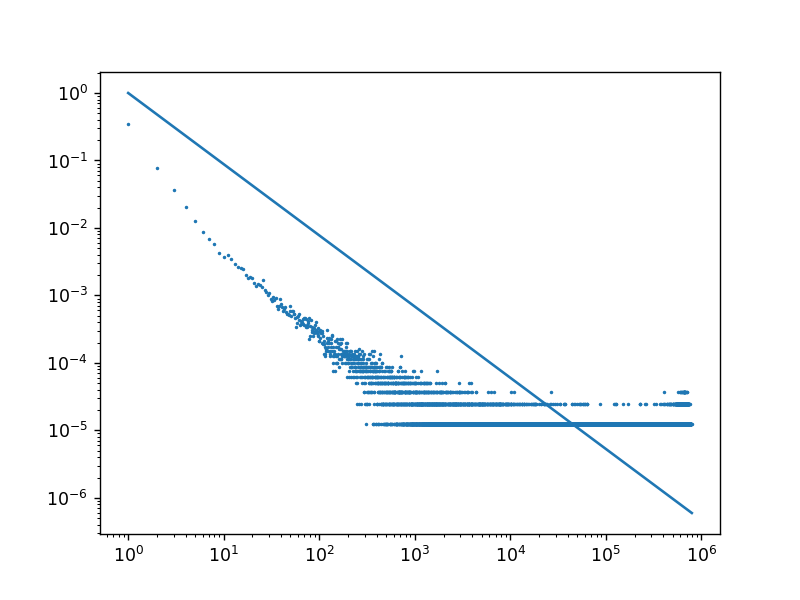

<IPython.core.display.Javascript object>


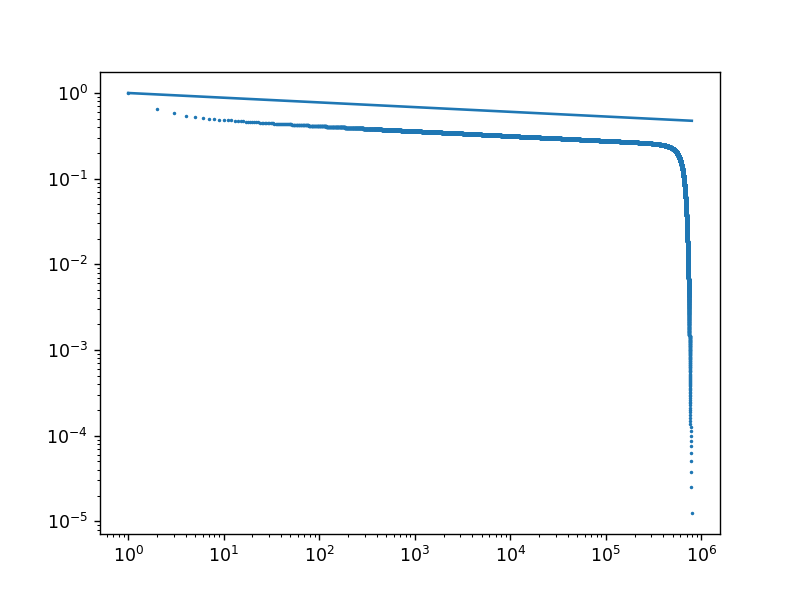

<IPython.core.display.Javascript object>


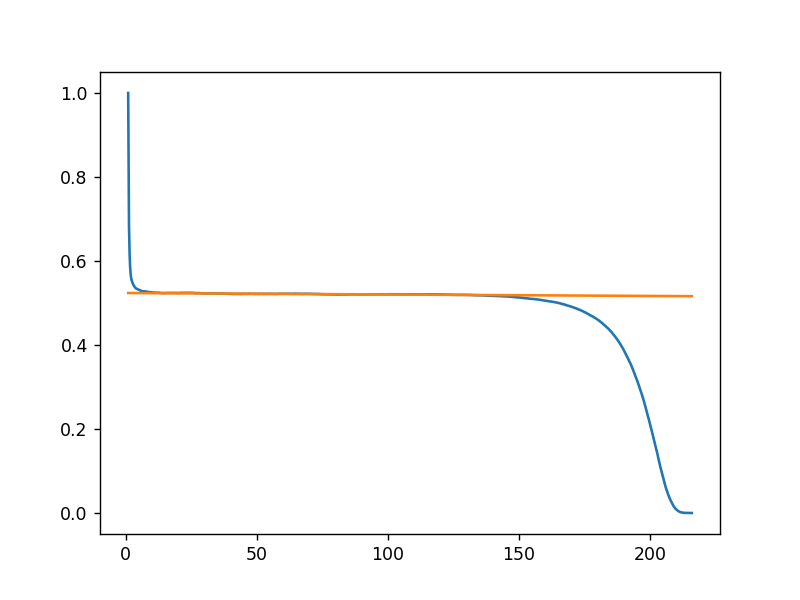

In [75]:
# 2806 [sec]
for f in ["s_list_80000_1024_0.528.npy"]:
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    s_sig = np.power(s, 36/91)
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    plt.close()
    plt.figure(1)
    plt.scatter(s, counts/np.sum(counts), s = 1)
    plt.plot(s, np.power(s, 1-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2)
    plt.scatter(s, pgts, s = 1)
    plt.plot(s, np.power(s, 2-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(3)
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts)
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    plt.plot(s_sig, k*s_sig + b)
plt.show()

In [7]:
plt.close()

<IPython.core.display.Javascript object>


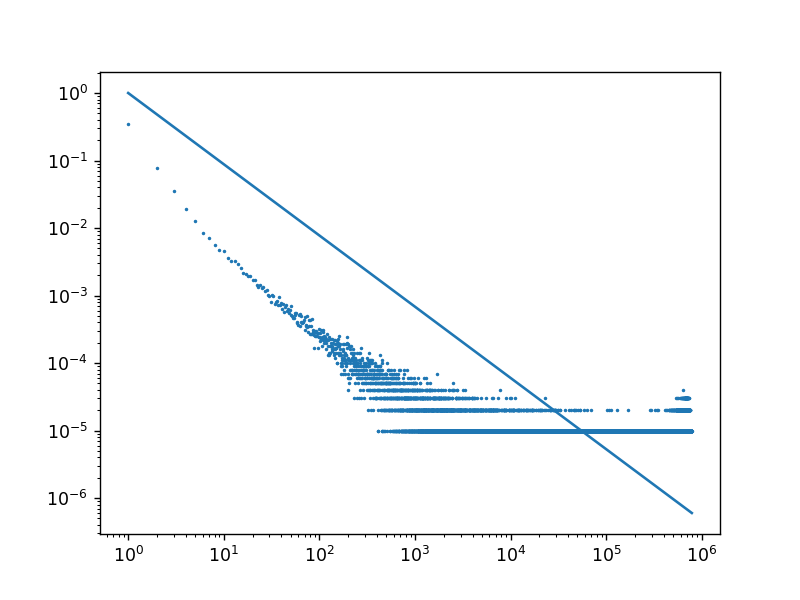

<IPython.core.display.Javascript object>


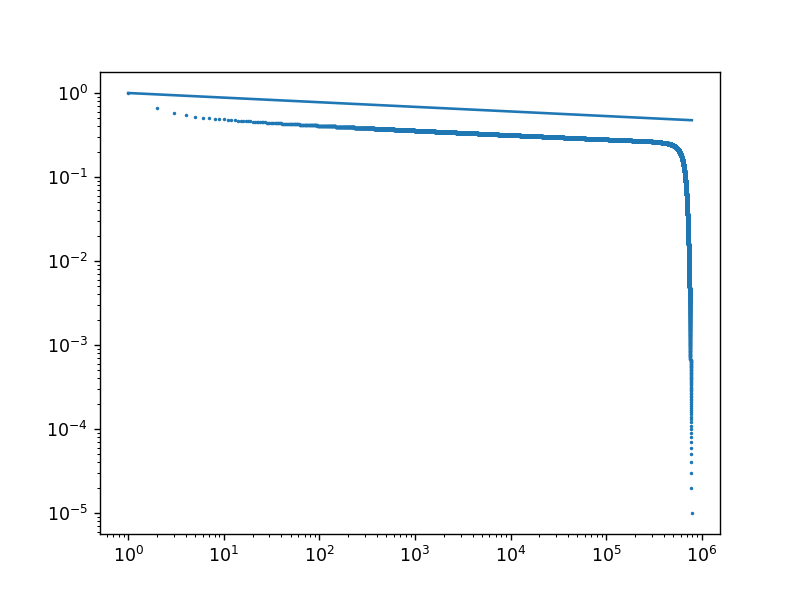

<IPython.core.display.Javascript object>


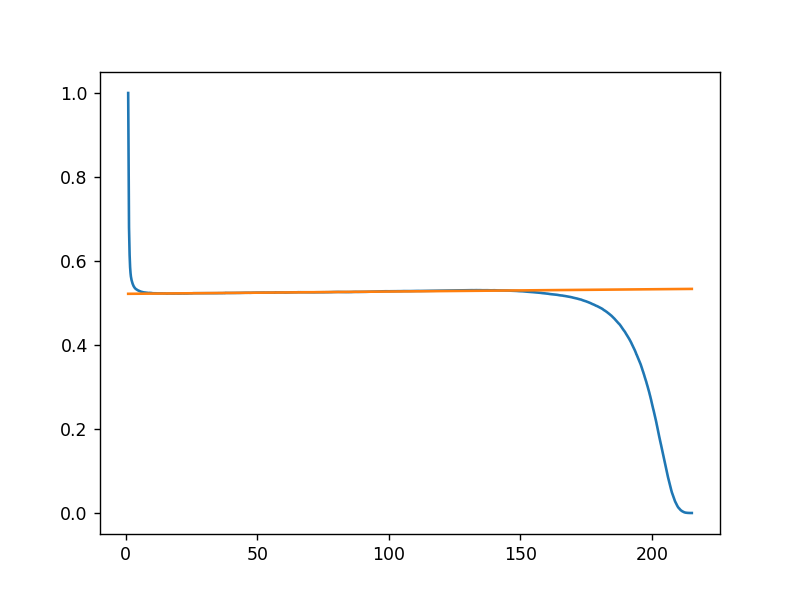

In [8]:
# 3436 [sec]
for f in ["s_list_100000_1024_0.5275.npy"]:
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    s_sig = np.power(s, 36/91)
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    plt.close()
    plt.figure(1)
    plt.scatter(s, counts/np.sum(counts), s = 1)
    plt.plot(s, np.power(s, 1-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2)
    plt.scatter(s, pgts, s = 1)
    plt.plot(s, np.power(s, 2-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(3)
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts)
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    plt.plot(s_sig, k*s_sig + b)
plt.show()

In [21]:
plt.close()

<IPython.core.display.Javascript object>


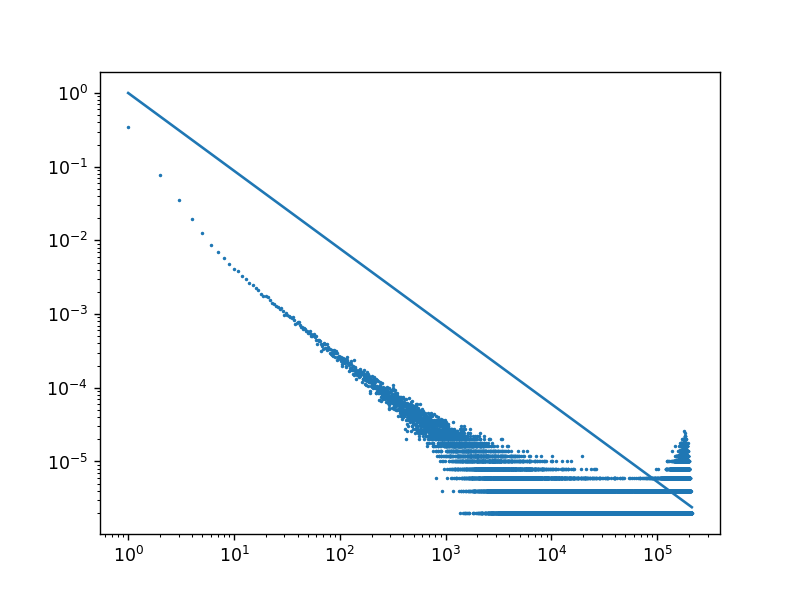

<IPython.core.display.Javascript object>


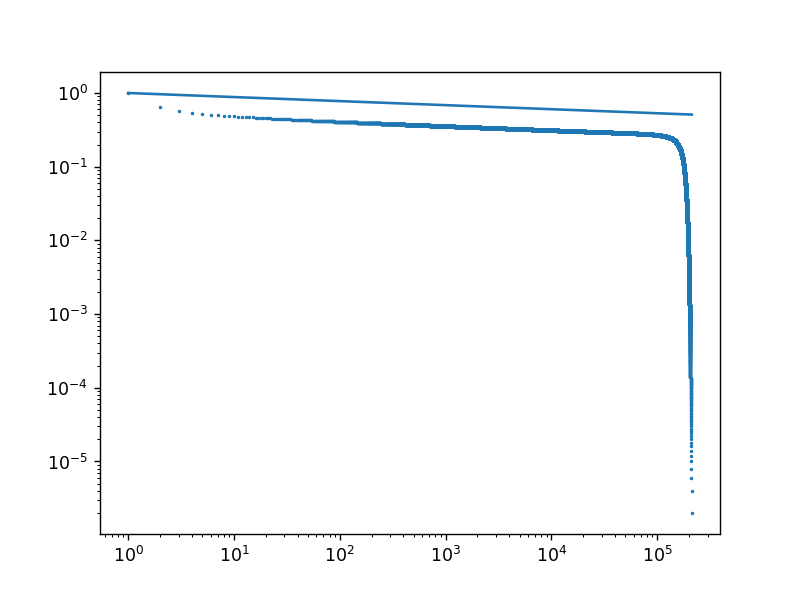

<IPython.core.display.Javascript object>


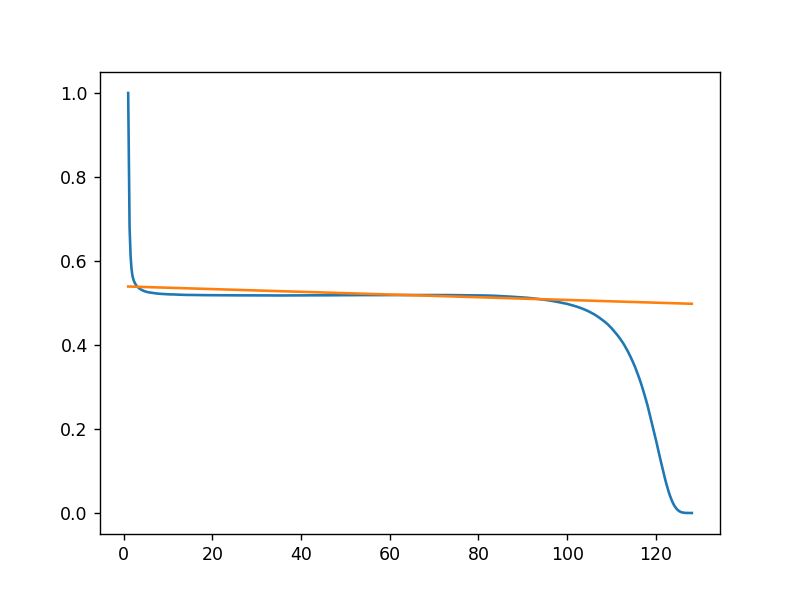

In [22]:
# 2815 [sec]
for f in ["s_list_500000_512_0.5278.npy"]:
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    s_sig = np.power(s, 36/91)
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    plt.close()
    plt.figure(1)
    plt.scatter(s, counts/np.sum(counts), s = 1)
    plt.plot(s, np.power(s, 1-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2)
    plt.scatter(s, pgts, s = 1)
    plt.plot(s, np.power(s, 2-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(3)
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts)
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    plt.plot(s_sig, k*s_sig + b)
plt.show()

In [19]:
plt.close()

<IPython.core.display.Javascript object>


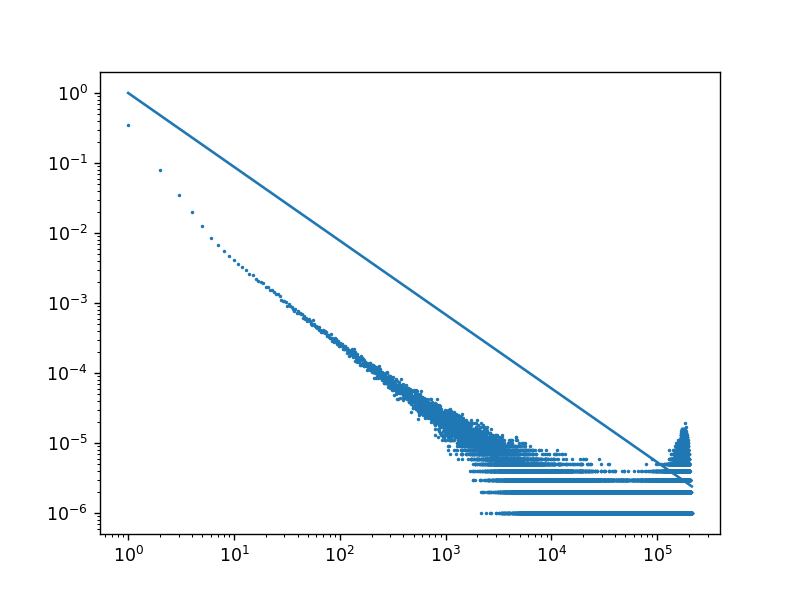

<IPython.core.display.Javascript object>


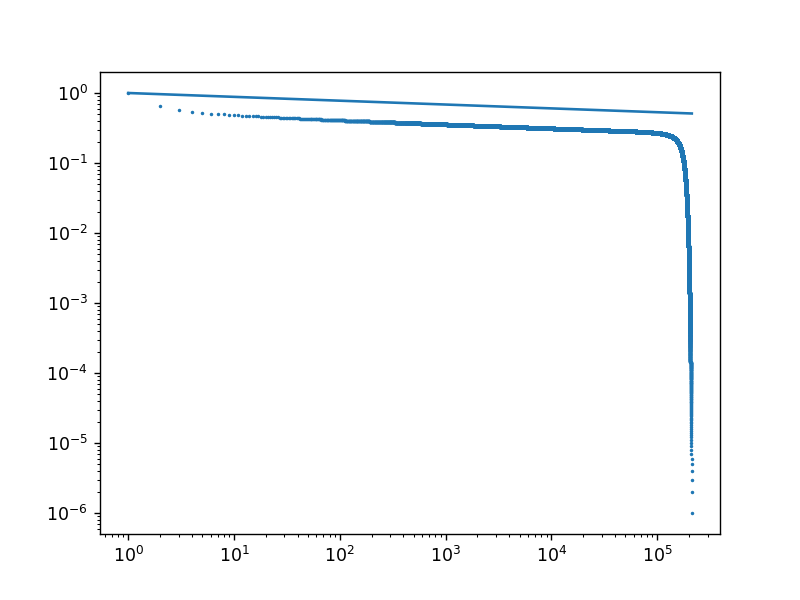

<IPython.core.display.Javascript object>


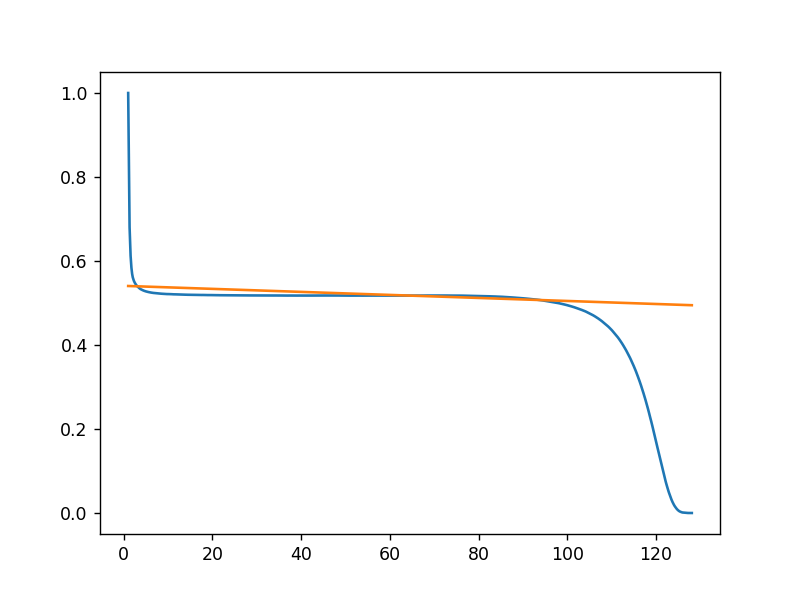

In [20]:
# 3752 [sec] (24 cores)
for f in ["s_list_1000000_512_0.5279.npy"]:
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    s_sig = np.power(s, 36/91)
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    plt.close()
    plt.figure(1)
    plt.scatter(s, counts/np.sum(counts), s = 1)
    plt.plot(s, np.power(s, 1-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(2)
    plt.scatter(s, pgts, s = 1)
    plt.plot(s, np.power(s, 2-187/91))
    plt.xscale('log')
    plt.yscale('log')
    
    plt.figure(3)
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts)
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    plt.plot(s_sig, k*s_sig + b)
plt.show()

### Best result seem to be 0.5279

In [16]:
plt.close()

<IPython.core.display.Javascript object>


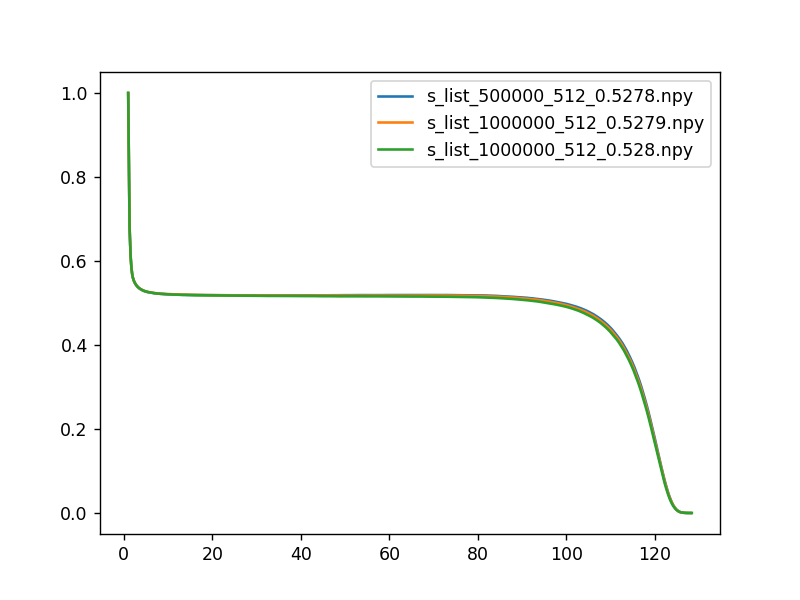

[]

In [18]:
k_list = []
b_list = []
alpha_list = [0.43834613, 0.43734613, 0.43634613]
plt.close()
for f in ["s_list_500000_512_0.5278.npy", "s_list_1000000_512_0.5279.npy", "s_list_1000000_512_0.528.npy"]: # N = 50000 ; L = 1024; Euler: 16 cpus, 10min
    
    s_list = np.load(f, allow_pickle = False)
    s, counts = np.unique(s_list, return_counts = True)
    
    s_sig = np.power(s, 36/91)
    
    pgts = (np.sum(counts) - np.cumsum(counts) + counts)/np.sum(counts)
    
    plt.plot(s_sig, np.power(s, 187/91-2)*pgts, label=f)
    
    k, b = np.polyfit(s_sig[(s_sig >= 50)*(s_sig <= 100)],  (np.power(s, 187/91-2)*pgts)[(s_sig >= 50)*(s_sig <= 100)], 1)
    
    #plt.plot(s_sig, k*s_sig + b)
    
    k_list.append(k)
    b_list.append(b)
plt.legend()
plt.plot()
    


<IPython.core.display.Javascript object>


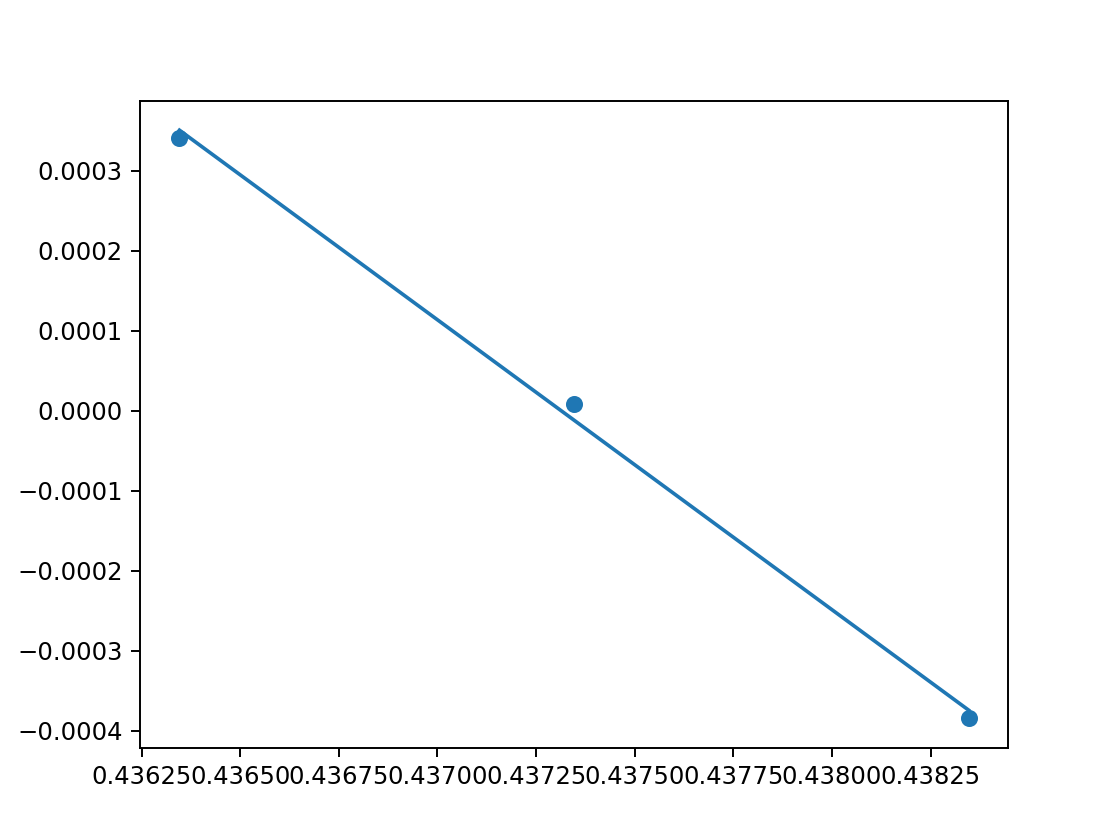

In [38]:
plt.scatter(alpha_list, k_list)
slope, intercept = np.polyfit(alpha_list, k_list, 1)
plt.plot(alpha_list, slope*np.array(alpha_list) + intercept)

In [ ]:
# for Euler

env2lmod #load new software stack

module load gcc/8.2.0  #load modules

module load python/3.8.5  #python with numba

bsub -n 16 -W 1:00 -R "rusage[mem=1024]" "python3 cluster.py > cluster.out" # 16 processors, 1 hour